# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import matplotlib.gridspec as gridspec
from copy import deepcopy
import matplotlib.cm as cm
import matplotlib.animation as animation
from scipy.stats import norm, uniform, truncnorm
from multiprocessing import Pool
from scipy.optimize import least_squares
from scipy.stats import binned_statistic
import corner
import astropy.units as u
from astropy.timeseries import LombScargle
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

# Loading sage 
import sys
import os
sys.path.append('/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/sage_output')
from sage import sage_class

# Functions

In [2]:
def eval_sage(params, time, args):
    # disintegrating the params to make it usable in sage. 
    #% Spots
    spot_long= []
    spot_lat=[]
    spot_size= []
    for spot_param, spot_list in zip(['lat', 'long', 'size'], [spot_lat, spot_long, spot_size]):
        for num in range(args['spotnumber']):
            param_name = f'spot{num+1}_{spot_param}'
            if param_name in args['var_param_list']:spot_list.append(params[args['var_param_list'].index(param_name)])
            elif param_name in args['fix_param_list']:spot_list.append(args['fix_param_values'][args['fix_param_list'].index(param_name)])

    #% All others
    add_param_values = {'offset': 0.,'jitter': 0.,'Prot': 0.,'sp_ctrst': 0.}

    # Update values from args
    for key in add_param_values:
        if key in args['var_param_list']:
            add_param_values[key] = params[args['var_param_list'].index(key)]
        elif key in args['fix_param_list']:
            add_param_values[key] = args['fix_param_values'][args['fix_param_list'].index(key)]

    # Extract final values
    offset = add_param_values['offset']
    jitt = add_param_values['jitter']
    prot = add_param_values['Prot']
    spotcontrast = add_param_values['sp_ctrst']

    # inclination= params[-1] # inclination of star
    inclination=90.

    # defining wavelength params
    wavelength= [5000]  # cal wavelength [pretty much useless]
    flux_hot=[1]        # immaculate photosphere
    flux_cold= [1 * spotcontrast]   #[0.2691] # contrast

    u1= 0.63
    u2= 0.15

    stellar_params=[0.0488,                                    # Radius-ratio   
                18.79,                                     # scaled semi-major axis 
                u1,                                        # U1
                u2,                                        # U2
                0.0,                                       # cosine of angular distance
                0.0,                                       # Intensity profile 
                inclination]                               

    planet_pixel_size= 10

    ve=(2*np.pi*0.744*696340)/(prot*24*3600)

    model_lightcurve = np.empty(len(time))
    contam_factors = np.zeros(len(time), dtype=object)
    star_maps = np.zeros(len(time), dtype=object)

    for i, ti in enumerate(time):
        
        phase_roti = ((2*np.pi)/prot) * (ti - time[0])

        star = sage_class(stellar_params, planet_pixel_size, wavelength, flux_hot, flux_cold, 
                spot_lat, spot_long, spot_size, ve, args['spotnumber'], 'multi-color', 5000, phases_rot=[np.rad2deg(phase_roti) * u.deg])

        flux_norm, contam_factor, star_map= star.rotate_star()

        model_lightcurve[i] = flux_norm 
        contam_factors[i] = contam_factor
        star_maps[i] = star_map
    
    #Adding the offset in the event of a visit concatenation
    if args['concat_fit']:
        for iconcat in range(args['local_output_dic']['num_concat_LCs']):
            if f'LC_offset{iconcat+1}' in args['var_param_list']:
                LC_offset = params[args['var_param_list'].index(f'LC_offset{iconcat+1}')]
            elif f'LC_offset{iconcat+1}' in args['fix_param_list']:
                LC_offset = args['fix_param_values'][args['fix_param_list'].index(f'LC_offset{iconcat+1}')]
            time_mask = ((time <= args['local_output_dic']['concat_ts'][iconcat][-1]) & (time >= args['local_output_dic']['concat_ts'][iconcat][0]))
            model_lightcurve[time_mask] += LC_offset

    return model_lightcurve + offset, contam_factors, star_maps, jitt

# Defining parameters

In [3]:
# Defining sectors to use and LCs for each sector 
#% For analysis of individual LCs
sectors_dic = {1:[1,2], 27:[1,2]}
sectors = list(sectors_dic.keys())

#Defining relevant directories
#% Location of raw data
data_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/AUMic_data/Formatted_TESS/'
#% Location of fit results
fit_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/Server_Runs/NARROW/2/'
#% Location to output plots
output_dir = '/Users/samsonmercier/Desktop/Work/Master/2023-2024/SAGE/Server_Runs/NARROW/2_postproc/'


#Defining dictionary with planet information -> to remove their transits
planet_propdic = {}
planet_propdic['AUMicb']={}
planet_propdic['AUMicb']['T0'] = 2458330.39051 #BJD
planet_propdic['AUMicb']['period'] = 8.463000  #days
planet_propdic['AUMicb']['T14'] = 3.4927/24    #days

planet_propdic['AUMicc']={}
planet_propdic['AUMicc']['T0'] = 2458342.2240 #BJD
planet_propdic['AUMicc']['period'] = 18.85969  #days
planet_propdic['AUMicc']['T14'] = 4.236/24    #days

planet_list = list(planet_propdic.keys())

#Defining the flare sigma-clipping thresholds
#% For analysis of individual LCs
sigma_dic = {1:[1.5, 2.5], 27:[1.5, 1.5]}

# Defining rolling median function
def rolling_median(data, window):
    half_window = window // 2
    medians = np.full_like(data, np.nan)
    for i in range(half_window, len(data) - half_window):
        medians[i] = np.median(data[i - half_window:i + half_window + 1])
    return medians

#Defining number of points to bin each LC to
nbins = 500

#Toggle to swap from individual to concatenated LC fits
concat_fit = True

#Defining dictionary to store output from pre-processing of each LC
output_dic = {}

# Defining time window of sectors to fit
#% For analysis of concatenated LCs
time_window_dic = {'sector_1':{'LC_1':'all'},
                    'sector_27':{'LC_1':'all'}}

#Initial guesses
#Prot in days
#lat, long, size in degrees
#% For analysis of concatenated LCs
guess_dic = {
        'sector_1':{
            'LC_1':{
                'spot1_lat': {'vary':True, 'guess':-30, 'bounds':[-50, -10]},
                'spot2_lat': {'vary':True, 'guess':40, 'bounds':[20, 60]},
                'spot3_lat': {'vary':True, 'guess':0, 'bounds':[-50, 50]},
                'spot1_long': {'vary':True, 'guess':-100, 'bounds':[-120, -80]},
                'spot2_long': {'vary':True, 'guess':80, 'bounds':[60, 100]},
                'spot3_long': {'vary':True, 'guess':0, 'bounds':[-100, 100]},
                'spot1_size': {'vary':True, 'guess':8, 'bounds':[1, 15]},
                'spot2_size': {'vary':True, 'guess':15, 'bounds':[1, 25]},
                'spot3_size': {'vary':True, 'guess':2, 'bounds':[1, 15]},
                'offset': {'vary':False, 'guess':0., 'bounds':[0.001, 0.1]},
                'jitter': {'vary':True, 'guess':-10, 'bounds':[-12, 10]},
                'Prot': {'vary':True, 'guess':'LS'},
                'sp_ctrst': {'vary':False, 'guess':0.2,'bounds':[0.4, 0.8]},
                'LC_offset1': {'vary':True, 'guess':0., 'bounds':[-1, 1]},
                'LC_offset2': {'vary':True, 'guess':0., 'bounds':[-1, 1]},
            }},
        'sector_27':{
            'LC_1':{
                'spot1_lat': {'vary':True, 'guess':-30, 'bounds':[-50, -10]},
                'spot2_lat': {'vary':True, 'guess':40, 'bounds':[20, 60]},
                'spot3_lat': {'vary':True, 'guess':0, 'bounds':[-50, 50]},
                'spot1_long': {'vary':True, 'guess':-100, 'bounds':[-120, -80]},
                'spot2_long': {'vary':True, 'guess':80, 'bounds':[60, 100]},
                'spot3_long': {'vary':True, 'guess':0, 'bounds':[-100, 100]},
                'spot1_size': {'vary':True, 'guess':8, 'bounds':[1, 15]},
                'spot2_size': {'vary':True, 'guess':15, 'bounds':[1, 25]},
                'spot3_size': {'vary':True, 'guess':2, 'bounds':[1, 15]},
                'offset': {'vary':False, 'guess':0., 'bounds':[0.001, 0.1]},
                'jitter': {'vary':True, 'guess':-10, 'bounds':[-12, 10]},
                'Prot': {'vary':True, 'guess':'LS'},
                'sp_ctrst': {'vary':False, 'guess':0.2,'bounds':[0.4, 0.8]},
                'LC_offset1': {'vary':True, 'guess':0., 'bounds':[-0.001, 0.001]},
                'LC_offset2': {'vary':True, 'guess':0.006, 'bounds':[0.005, 0.007]},
            }}
}

#Priors
#% For analysis of concatenated LCs
priors_dic = {
        'sector_1':{
            'LC_1':{
                'spot1_lat': {'type':'uf', 'min':-80, 'max':0.},
                'spot2_lat': {'type':'uf', 'min':0, 'max':80},
                'spot3_lat': {'type':'uf', 'min':-80, 'max':80},
                'spot1_long': {'type':'uf', 'min':-180, 'max':180},
                'spot2_long': {'type':'uf', 'min':-180, 'max':180},
                'spot3_long': {'type':'uf', 'min':-180, 'max':180},
                'spot1_size': {'type':'uf', 'min':0, 'max':90},
                'spot2_size': {'type':'uf', 'min':0, 'max':90},
                'spot3_size': {'type':'uf', 'min':0, 'max':90},
                # 'offset': {'type':'uf', 'min':-1.5, 'max':2.5},
                'jitter': {'type':'uf', 'min':-15, 'max':15},
                'Prot': {'type':'LS'},
                # 'sp_ctrst': {'type':'uf', 'min':0., 'max':1.},
                'LC_offset1': {'type':'uf', 'min':-1, 'max':1},
                'LC_offset2': {'type':'uf', 'min':-1, 'max':1},
            }},
        'sector_27':{
            'LC_1':{
                'spot1_lat': {'type':'uf', 'min':-80, 'max':0.},
                'spot2_lat': {'type':'uf', 'min':0, 'max':80},
                'spot3_lat': {'type':'uf', 'min':-80, 'max':80},
                'spot1_long': {'type':'uf', 'min':-180, 'max':180},
                'spot2_long': {'type':'uf', 'min':-180, 'max':180},
                'spot3_long': {'type':'uf', 'min':-180, 'max':180},
                'spot1_size': {'type':'uf', 'min':0, 'max':90},
                'spot2_size': {'type':'uf', 'min':0, 'max':90},
                'spot3_size': {'type':'uf', 'min':0, 'max':90},
                # 'offset': {'type':'uf', 'min':-1.5, 'max':2.5},
                'jitter': {'type':'uf', 'min':-15, 'max':15},
                'Prot': {'type':'LS'},
                # 'sp_ctrst': {'type':'uf', 'min':0., 'max':1.},
                'LC_offset1': {'type':'uf', 'min':-1, 'max':1},
                'LC_offset2': {'type':'uf', 'min':-1, 'max':1},
            }},
}

#Defining dictionary for post-processing settings
postproc_dic = {}

#Defining MCMC settings
postproc_dic['nsteps'] = 5000
postproc_dic['nburn'] = 3000

#Sigma clipping threshold
postproc_dic['trace_sig_clip'] = 2.5

#Defining dictionary to remove walkers manually
walk_exclu_dic = {
        'sector_1':{
            'LC_1':[]},
        'sector_27':{
            'LC_1':[]},
}

#Numer of time steps for the GIF to plot the system view 
postproc_dic['ntstep_GIF_sys_view'] = 51

# Retrieving data

SECTOR N.1, LC N.1
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


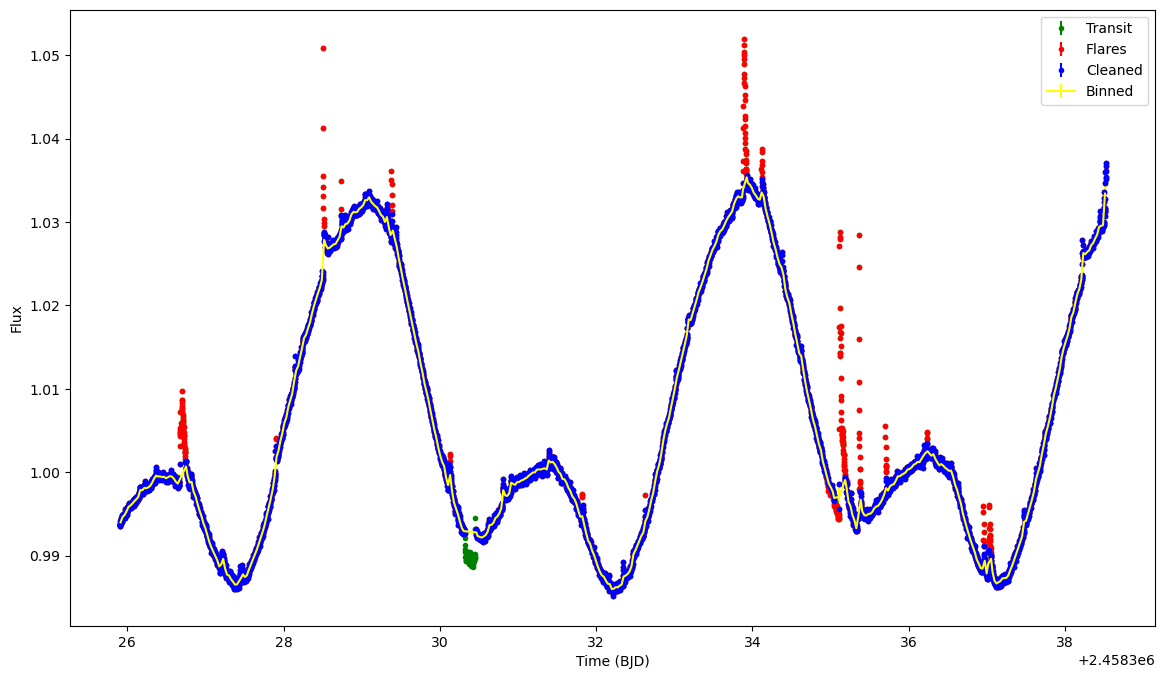

SECTOR N.1, LC N.2
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


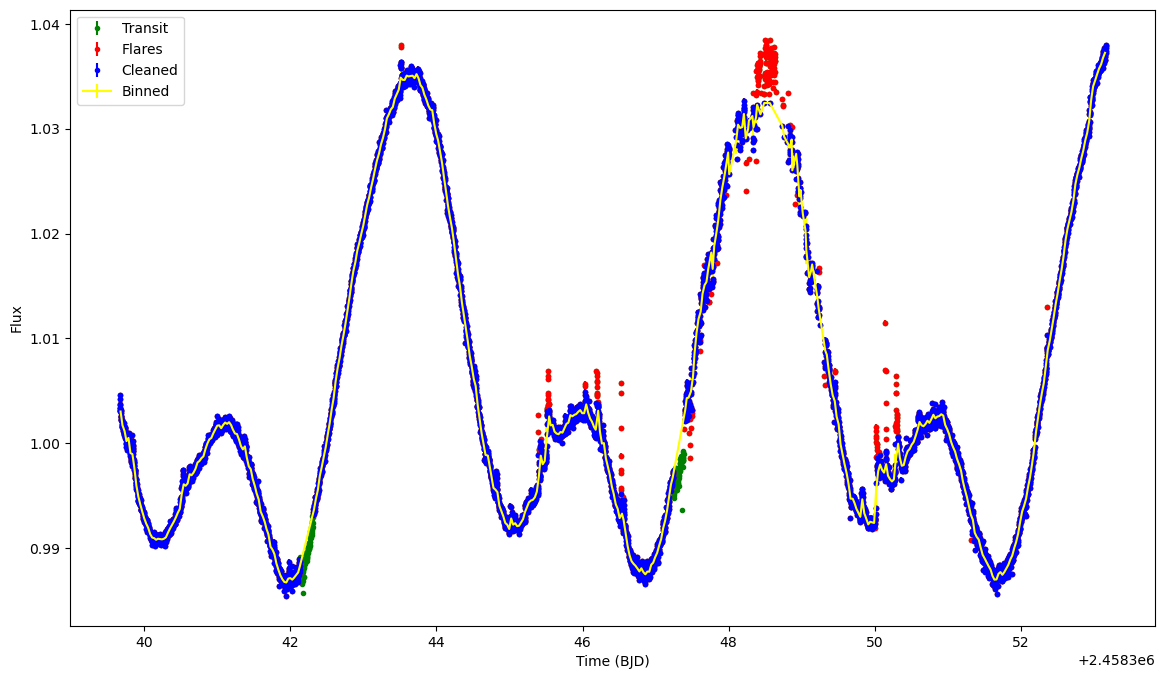

SECTOR N.27, LC N.1
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


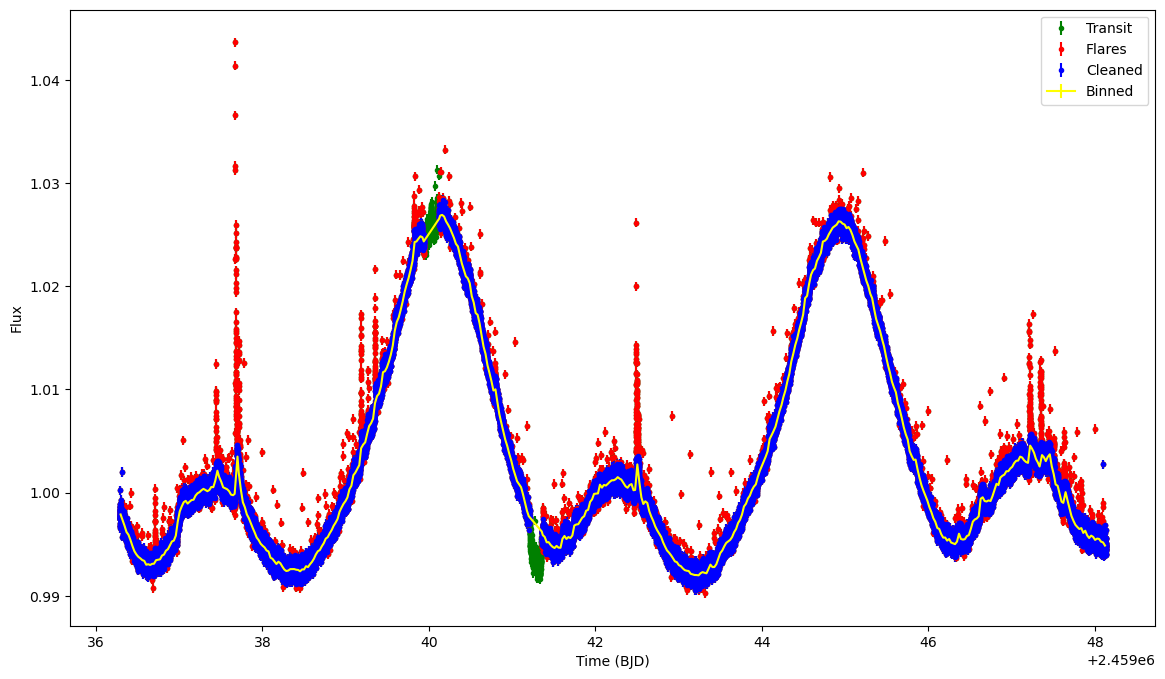

SECTOR N.27, LC N.2
RETRIEVING DATA
REMOVING TRANSIT
REMOVING FLARES
BINNING DATA


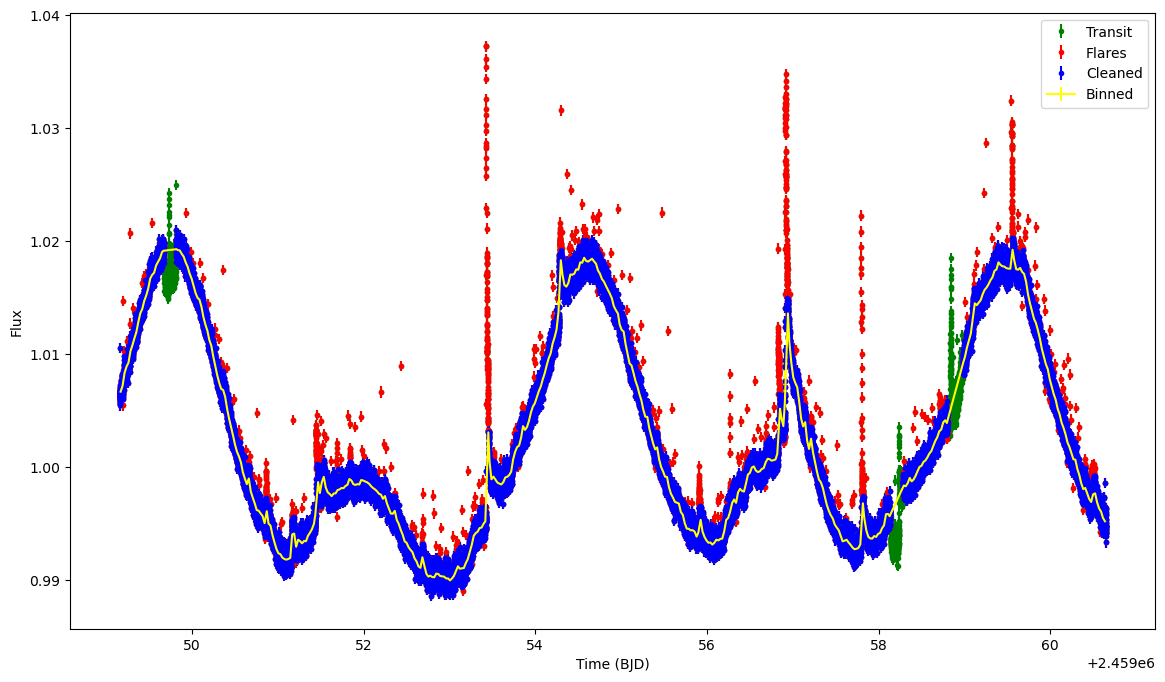

In [4]:
#Making sure the output directory exists
if not os.path.isdir(output_dir):os.makedirs(output_dir)

#Looping over sectors
for sector in sectors:
    #Getting sector name
    sector_name = f'sector_{sector}'
    sector_dir = output_dir+'/'+sector_name
    if not os.path.isdir(sector_dir):os.makedirs(sector_dir)
    output_dic[sector_name]={}

    #Looping over each transit
    for transitidx, transitnum in enumerate(sectors_dic[sector]):
        
        #Getting transit name
        LC_name = f'LC_{transitnum}'
        LC_dir = sector_dir+'/'+LC_name
        if not os.path.isdir(LC_dir):os.makedirs(LC_dir)
        output_dic[sector_name][LC_name]={}

        #Print
        print(f'SECTOR N.{sector}, LC N.{transitnum}')
        plt.figure(figsize=[14, 8])

        #Retrieving data
        print('RETRIEVING DATA')
        pd_data= pd.read_csv(data_dir + f'/Sector_{sector}/LC_{sector}_{transitnum}.csv')

        #Retrieving raw data
        mask_finite_flux = np.isfinite(pd_data['flux'])
        t = pd_data['time'][mask_finite_flux] + 2457000 #converting TESS BJD to BJD
        flux = pd_data['flux'][mask_finite_flux]
        flux_err = pd_data['flux_err'][mask_finite_flux]

        #Removing transit of planet considered   
        print('REMOVING TRANSIT')
        #% Defining mask to figure out the timestamps of in-transit exposures
        IT_mask = np.zeros(len(t), dtype=bool)

        #% Looping over all known planets in the system just in case
        for planet in planet_list:
            #% Getting planet properties 
            planet_dic = planet_propdic[planet]

            #% Number of transits that happened during epoch considered
            n_low  = np.round((min(t) - planet_dic['T0'])/planet_dic['period'], 0)
            n_high = np.round((max(t) - planet_dic['T0'])/planet_dic['period'], 0)
            #% Predicting transit midpoints during epoch considered
            predicted_T0s = planet_dic['T0'] + np.arange(n_low, n_high+1, 1)*planet_dic['period']

            #%Looping over all transits in epoch considered and updating mask to remove them
            for predicted_T0 in predicted_T0s:
                IT_mask |= (t>predicted_T0-(planet_dic['T14']/2)) & (t<predicted_T0+(planet_dic['T14']/2))

        #Plotting transits before and after
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='green', label='Transit')
        t = t[~IT_mask]
        flux = flux[~IT_mask]
        flux_err = flux_err[~IT_mask]

        #Removing flares
        print('REMOVING FLARES')

        #% compute rolling median of the LC
        rolling_med = rolling_median(flux, window=300)

        #% "Normalize" LC
        raw_norm_flux = flux/rolling_med
        norm_flux = raw_norm_flux[~np.isnan(raw_norm_flux)]

        #% Sigma clip to remove flares
        sigma=sigma_dic[sector][transitidx]
        flare_mask = ((raw_norm_flux < np.median(norm_flux) - sigma*np.std(norm_flux)) | (raw_norm_flux > np.median(norm_flux) + sigma*np.std(norm_flux)))  

        #Masking points
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='red', label='Flares')
        t=t[~flare_mask]
        flux=flux[~flare_mask]
        flux_err=flux_err[~flare_mask]


        #Binning data to make MCMC easier
        print('BINNING DATA')
        binned_t = binned_statistic(t, t, statistic='mean', bins=nbins)[0]
        binned_flux = binned_statistic(t, flux, statistic='mean', bins=nbins)[0]
        binned_flux_err = binned_statistic(t, flux, statistic='std', bins=nbins)[0]

        #Final cleaned result
        binned_flux = binned_flux[~np.isnan(binned_t)]
        binned_flux_err = binned_flux_err[~np.isnan(binned_t)]
        binned_t = binned_t[~np.isnan(binned_t)]
        output_dic[sector_name][LC_name]['t'] = binned_t
        output_dic[sector_name][LC_name]['flux'] = binned_flux
        output_dic[sector_name][LC_name]['flux_err'] = binned_flux_err
        plt.errorbar(t, flux, yerr=flux_err, fmt='.', color='blue', label='Cleaned')
        plt.errorbar(binned_t, binned_flux, yerr=binned_flux_err, color='yellow', linestyle='-', label='Binned')        
        plt.legend()
        plt.xlabel('Time (BJD)')
        plt.ylabel('Flux')
        # plt.savefig(LC_dir+'/input_LC.pdf')
        plt.show()
        plt.close()


# Swapping to one LC fit per visit

In [5]:
if concat_fit:
    old_output_dic = deepcopy(output_dic)
    output_dic = {}
    for sector in sectors:
        #Plot the concatenated LCs
        plt.figure(figsize=[14, 8])
        plt.title(f'Sector {sector} concatenated LCs')
        for LC in sectors_dic[sector]:
            LC_name = f'LC_{LC}'
            t = old_output_dic[f'sector_{sector}'][LC_name]['t']
            flux = old_output_dic[f'sector_{sector}'][LC_name]['flux']
            flux_err = old_output_dic[f'sector_{sector}'][LC_name]['flux_err']
            plt.errorbar(t, flux, yerr=flux_err, fmt='.', label=LC_name)
        plt.xlabel('Time (BJD)')
        plt.ylabel('Flux')
        plt.savefig(output_dir+f'/sector_{sector}/concat_LC.pdf')
        plt.close()

        #Ensure the user defined the right format for the guess and priors dictionaries
        if (len(guess_dic[f'sector_{sector}']) != 1) or (len(priors_dic[f'sector_{sector}']) != 1) or (len(time_window_dic[f'sector_{sector}']) != 1):
            raise ValueError(f"Guess, prior, and time window dictionaries must have only one LC per sector when using concatenated LCs. Found {len(guess_dic[f'sector_{sector}'])}, {len(priors_dic[f'sector_{sector}'])}, and {len(time_window_dic[f'sector_{sector}'])} respectively.")

        #Store the output directory of the concatenated LCs
        output_dic[f'sector_{sector}'] = {}
        output_dic[f'sector_{sector}']['LC_1'] = {}
        output_dic[f'sector_{sector}']['LC_1']['num_concat_LCs'] = len(sectors_dic[sector])
        output_dic[f'sector_{sector}']['LC_1']['concat_ts'] = [old_output_dic[f'sector_{sector}'][f'LC_{i+1}']['t'] for i in range(output_dic[f'sector_{sector}']['LC_1']['num_concat_LCs'])]
        for entry in ['t', 'flux', 'flux_err']:
            output_dic[f'sector_{sector}'][f'LC_1'][entry] = np.concatenate([old_output_dic[f'sector_{sector}'][f'LC_{i+1}'][entry] for i in range(output_dic[f'sector_{sector}']['LC_1']['num_concat_LCs'])])

        sectors_dic[sector] = [1] #Only one LC per sector

        #Delete the old directory
        for subdir in os.listdir(output_dir+f'/sector_{sector}'):
            if ('LC_' in subdir) and (subdir != 'LC_1'):os.rmdir(output_dir+f'sector_{sector}/'+subdir)


# Retrieving and post-processing fit data

SECTOR N.1, LC N.1
PLOTTING: TRACE
Removing 3 walkers from the chain due to large deviations and 0 from manual user action.
------------------------
FITTED PARAMETERS:
    spot1_lat: -59.660 / -58.581 +/- 2.242
    spot2_lat: 55.196 / 57.160 +/- 1.970
    spot3_lat: -60.133 / -58.026 +/- 1.558
    spot1_long: -134.782 / -137.740 +/- 4.464
    spot1_Tc: 2458327.732 +/- 0.060 / 2458327.772 +/- 0.060
    spot2_long: 22.477 / 22.317 +/- 0.450
    spot2_Tc: 2458325.611 +/- 0.006 / 2458325.613 +/- 0.006
    spot3_long: -88.469 / -88.474 +/- 2.658
    spot3_Tc: 2458327.107 +/- 0.036 / 2458327.108 +/- 0.036
    spot1_size: 14.234 / 13.382 +/- 1.798
    spot2_size: 16.353 / 17.089 +/- 0.620
    spot3_size: 16.018 / 15.305 +/- 0.997
    jitter: -6.846 / -6.886 +/- 0.042
    Prot: 4.857 / 4.857 +/- 0.001
    LC_offset1: 0.034 / 0.035 +/- 0.000
    LC_offset2: 0.035 / 0.035 +/- 0.000
------------------------
FIXED PARAMETERS
    offset: 0.0
    sp_ctrst: 0.2
------------------------
PLOTTING: CORN

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


SECTOR N.27, LC N.1
PLOTTING: TRACE
Removing 7 walkers from the chain due to large deviations and 0 from manual user action.
------------------------
FITTED PARAMETERS:
    spot1_lat: -20.732 / -8.393 +/- 8.845
    spot2_lat: 45.540 / 45.808 +/- 5.480
    spot3_lat: -74.928 / -77.395 +/- 1.636
    spot1_long: -97.182 / -91.515 +/- 5.816
    spot1_Tc: 2459037.602 +/- 0.078 / 2459037.526 +/- 0.078
    spot2_long: -14.165 / -13.060 +/- 1.322
    spot2_Tc: 2459036.486 +/- 0.018 / 2459036.471 +/- 0.018
    spot3_long: -173.989 / -169.563 +/- 3.347
    spot3_Tc: 2459038.635 +/- 0.045 / 2459038.575 +/- 0.045
    spot1_size: 5.628 / 4.622 +/- 0.463
    spot2_size: 11.779 / 12.042 +/- 1.052
    spot3_size: 24.222 / 27.050 +/- 1.725
    jitter: -6.279 / -6.279 +/- 0.028
    Prot: 4.840 / 4.840 +/- 0.003
    LC_offset1: 0.028 / 0.031 +/- 0.001
    LC_offset2: 0.025 / 0.028 +/- 0.001
------------------------
FIXED PARAMETERS
    offset: 0.0
    sp_ctrst: 0.2
------------------------
PLOTTING: CORN

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


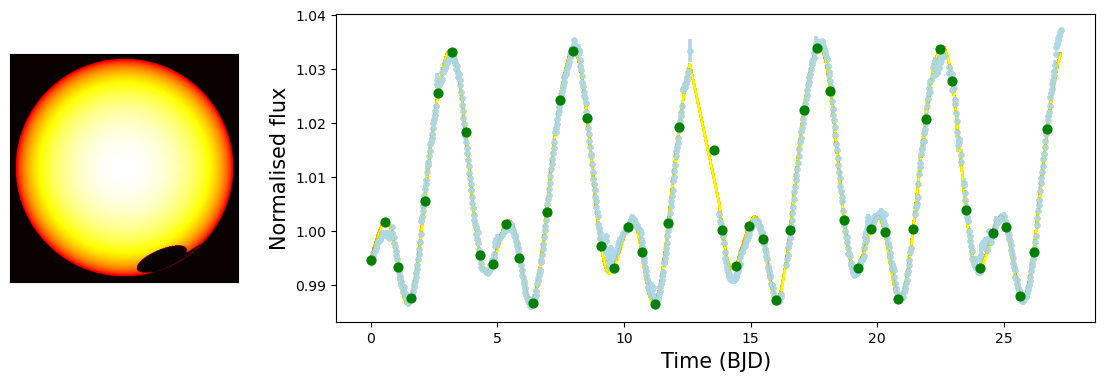

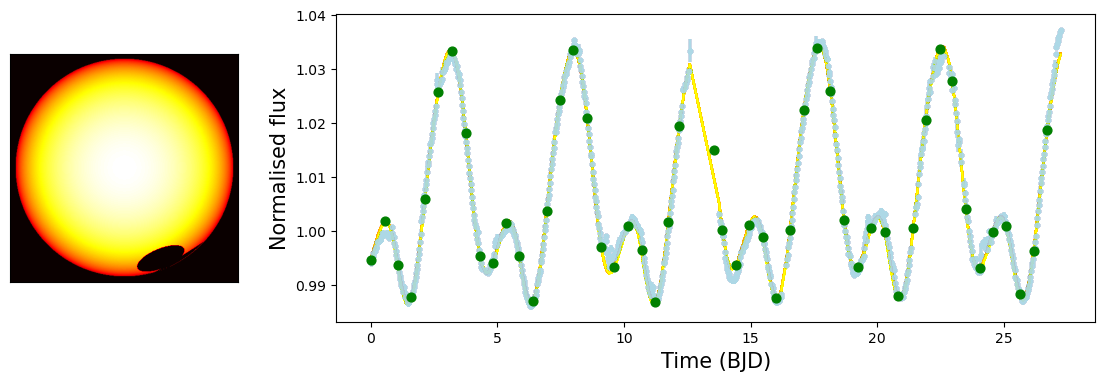

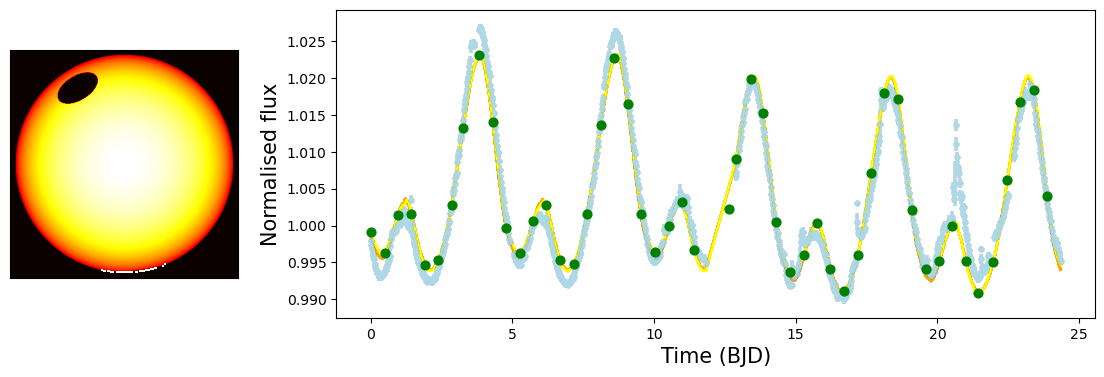

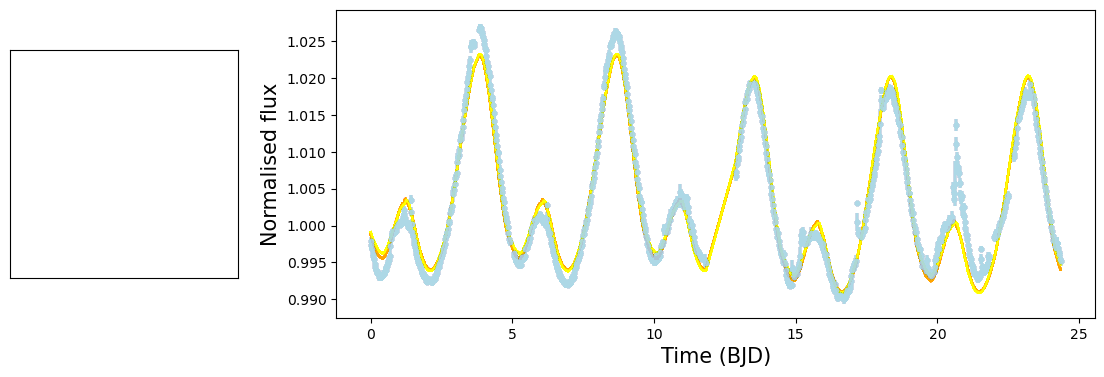

In [6]:
for sector in sectors:
    sector_name = f'sector_{sector}'
    sector_dir = output_dir+'/'+sector_name
    #Looping over each transit
    for transitidx, transitnum in enumerate(sectors_dic[sector]):
        LC_name = f'LC_{transitnum}'
        LC_dir = sector_dir+'/'+LC_name
        print(f'SECTOR N.{sector}, LC N.{transitnum}')

        #Loading data
        local_guess_dic = guess_dic[sector_name][LC_name]
        local_output_dic = output_dic[sector_name][LC_name]
        local_walk_exclu_list = walk_exclu_dic[sector_name][LC_name]

        #Defining important lists
        ndim=0
        var_param_list = []
        fix_param_list = []
        fix_param_values = []
        for key in local_guess_dic:
            if local_guess_dic[key]['vary']:
                var_param_list.append(str(key))
                ndim+=1
            else:
                fix_param_list.append(str(key))
                fix_param_values.append(local_guess_dic[key]['guess'])

        #%% Defining dictionary to store additional info. needed for the model
        postproc_dic['var_param_list']=var_param_list
        postproc_dic['fix_param_list']=fix_param_list
        postproc_dic['fix_param_values']=fix_param_values
        postproc_dic['all_param_list']=var_param_list+fix_param_list
        postproc_dic['ndim'] = len(postproc_dic['var_param_list'])

        #Finding the number of spots
        spotnames = []
        for key in local_guess_dic.keys():
            if ('spot' in key):spotnames.append(key.split('_')[0])
        postproc_dic['spotnumber'] = len(np.unique(spotnames))
        
        #Compute Lomb-Scargle periodogram - only if we fit period and use LS to initialize it
        min_period = 0.5
        max_period = 10.0
        frequency = np.linspace(1/max_period, 1/min_period, 10000)
        ls = LombScargle(local_output_dic['t'], local_output_dic['flux'])
        power = ls.power(frequency)
        best_frequency = frequency[np.argmax(power)]
        best_period = 1 / best_frequency
        if ('Prot' in postproc_dic['fix_param_list']) and (local_guess_dic['Prot']['guess'] == 'LS'):
            postproc_dic['fix_param_values'][postproc_dic['fix_param_list'].index('Prot')]=best_period

        #Retrieving raw chains
        raw_chain = np.load(fit_dir + f'/{sector_name}/{LC_name}/chains.npy')
        logprob = np.load(fit_dir + f'/{sector_name}/{LC_name}/logprob.npy')
        
        #Check the shapes
        postproc_dic['nwalkers'] = raw_chain.shape[0]
        if (raw_chain.shape[1] != postproc_dic['nsteps']) or (raw_chain.shape[2] != postproc_dic['ndim']):print('Inconsistent shapes in walker dimensions!!! Check what you input with respect to what is retrieved.')

        #Sigma clipping chains
        del_chain = []
        for ipar, param in enumerate(postproc_dic['var_param_list']):
            param_median = np.median(raw_chain[:,postproc_dic['nburn']:,ipar])
            param_std = np.std(raw_chain[:,postproc_dic['nburn']:,ipar])
            for iwalk in range(postproc_dic['nwalkers']):
                if (np.abs(raw_chain[iwalk, -1, ipar] - param_median) > postproc_dic['trace_sig_clip']*param_std):del_chain.append(iwalk)
        del_chain = np.unique(del_chain)
        
        #Doing manual walker exclusion if necessary
        user_del_chain = []
        if local_walk_exclu_list != []:
            for sub_param_list in local_walk_exclu_list:
                for iwalk in range(postproc_dic['nwalkers']):
                    param_chain = raw_chain[iwalk, postproc_dic['nburn']:, postproc_dic['var_param_list'].index(sub_param_list[0])]
                    if (sub_param_list[1] == 'lt'):
                        if (np.min(param_chain) < sub_param_list[2]) and (iwalk not in del_chain):user_del_chain.append(iwalk)
                    elif (sub_param_list[1] == 'mt'):
                        if (np.max(param_chain) > sub_param_list[2]) and (iwalk not in del_chain):user_del_chain.append(iwalk)
                    else: 
                        print(f'Incorrect chain removal key. Try again with lt or mt. You gave {sub_param_list[1]}.')
        user_del_chain = np.unique(user_del_chain)
        
        #Plotting the traces
        print('PLOTTING: TRACE')
        #% Plot
        fig2, axes = plt.subplots(postproc_dic['ndim'], 1, figsize=(10, 2*postproc_dic['ndim']), sharex=True)
        for i, param in enumerate(postproc_dic['var_param_list']):
            ax = axes[i]
            ax.axhline(np.median(raw_chain[:,  postproc_dic['nburn']:, i]), linestyle='--', color='black', zorder=2)
            for w in range(postproc_dic['nwalkers']):
                if w in del_chain:ax.plot(np.arange(postproc_dic['nsteps']), raw_chain[w, :, i], color='red', alpha=0.5, lw=0.7, zorder=1)
                elif w in user_del_chain:ax.plot(np.arange(postproc_dic['nsteps']), raw_chain[w, :, i], color='green', alpha=0.5, lw=0.7, zorder=1)
                else:
                    ax.plot(np.arange(postproc_dic['nburn']), raw_chain[w, :postproc_dic['nburn'], i], color='red', alpha=0.5, lw=0.7, zorder=1)
                    ax.plot(np.arange(postproc_dic['nburn'], postproc_dic['nsteps']), raw_chain[w, postproc_dic['nburn']:, i], color='blue', alpha=0.5, lw=0.7, zorder=1)
            ax.set_ylabel(param)
        axes[-1].set_xlabel("Step")
        plt.tight_layout()
        plt.savefig(LC_dir+'/trace.pdf')
        plt.close()
        
        #Doing the actual deletion
        print(f"Removing {len(del_chain)} walkers from the chain due to large deviations and {len(user_del_chain)} from manual user action.")
        full_del_chain = np.unique(list(del_chain) + list(user_del_chain))
        if len(full_del_chain) > 0:
            chain = np.delete(raw_chain, full_del_chain, axis=0)
        else:chain = np.copy(raw_chain)
        
        #Burning the chains
        burnt_chains = np.copy(chain[:, postproc_dic['nburn']:, :])
        flat_burnt_chains = np.reshape(burnt_chains, (burnt_chains.shape[0]*burnt_chains.shape[1], burnt_chains.shape[2]))
        
        #Extracting the highest log probability, median values, and errorbars of each parameter
        #% Median
        median_params = {}
        err_params = {}
        for i, param in enumerate(postproc_dic['var_param_list']):
            median_params[param] = np.median(flat_burnt_chains[:, i])
            err_params[param] = np.std(flat_burnt_chains[:, i])
        for idx, param in enumerate(postproc_dic['fix_param_list']):
            median_params[param] = postproc_dic['fix_param_values'][idx]
        
        #% Highest log-prob
        max_step, max_walker = np.unravel_index(np.argmax(logprob), logprob.shape)
        best_params = {}
        for i, param in enumerate(postproc_dic['var_param_list']):
            best_params[param] = raw_chain[max_walker, max_step, i]
        for idx, param in enumerate(postproc_dic['fix_param_list']):
            best_params[param] = postproc_dic['fix_param_values'][idx]

        #Printing outputs
        print('------------------------')
        print('FITTED PARAMETERS:')
        for param in postproc_dic['var_param_list']:
            print(f'    {param}: {median_params[param]:.3f} / {best_params[param]:.3f} +/- {err_params[param]:.3f}')
            median_per_to_use = median_params['Prot'] if 'Prot' in postproc_dic['var_param_list'] else postproc_dic['fix_param_values'][postproc_dic['fix_param_list'].index('Prot')]
            best_per_to_use = best_params['Prot'] if 'Prot' in postproc_dic['var_param_list'] else postproc_dic['fix_param_values'][postproc_dic['fix_param_list'].index('Prot')]
            err_per_to_use = err_params['Prot'] if 'Prot'in postproc_dic['var_param_list'] else 0.
            if 'long' in param:
                
                med_cross_time = local_output_dic['t'][0] - ((median_per_to_use * median_params[param])/(360))
                med_cross_time_err = np.sqrt( (median_per_to_use * err_params[param])**2 + (median_params[param] * err_per_to_use)**2 )/360
                
                best_cross_time = local_output_dic['t'][0] - ((best_per_to_use * best_params[param])/(360))
                best_cross_time_err = np.sqrt( (best_per_to_use * err_params[param])**2 + (best_params[param] * err_per_to_use)**2 )/360

                spot_name = param.split('_')[0]
                print(f'    {spot_name}_Tc: {med_cross_time:.3f} +/- {med_cross_time_err:.3f} / {best_cross_time:.3f} +/- {best_cross_time_err:.3f}')

        print('------------------------')
        print('FIXED PARAMETERS')
        for param, parval in zip(postproc_dic['fix_param_list'], postproc_dic['fix_param_values']):
            print(f'    {param}: {parval}')
        print('------------------------')
        
        #Making corner plot
        print('PLOTTING: CORNER')
        fig = corner.corner(burnt_chains, labels=postproc_dic['var_param_list'])
        plt.savefig(LC_dir+'/corner.pdf')
        plt.close()

        #Making best fit plot
        print('PLOTTING: BESTFIT AND MEDIAN')

        postproc_dic['concat_fit'] = concat_fit
        postproc_dic['local_output_dic'] = local_output_dic
        if ('Prot' in postproc_dic['fix_param_list']) and (local_guess_dic['Prot']['guess'] == 'LS'):
            postproc_dic['fix_param_values'][postproc_dic['fix_param_list'].index('Prot')]=best_period

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[3,1]}, figsize=[14, 4])
        ax1.errorbar(local_output_dic['t'], local_output_dic['flux'], yerr=local_output_dic['flux_err'], fmt='.', color='blue', label='Data', alpha=0.5)
        #Highest logprob
        best_fit_params = raw_chain[max_walker, max_step, :]
        #Median             
        median_params = np.median(flat_burnt_chains, axis=0)
        median_res = eval_sage(median_params, local_output_dic['t'], postproc_dic)[0]
        ax1.plot(local_output_dic['t'], median_res, color='yellow', label='Median Fit')
        ax2.errorbar(local_output_dic['t'], (local_output_dic['flux'] - median_res), yerr=local_output_dic['flux_err'], fmt='.', color='yellow')
        
        bestfit_res = eval_sage(best_fit_params, local_output_dic['t'], postproc_dic)[0]
        ax1.plot(local_output_dic['t'], bestfit_res, color='orange', label='Best Fit')
        ax2.errorbar(local_output_dic['t'], (local_output_dic['flux'] - bestfit_res), yerr=local_output_dic['flux_err'], fmt='.', color='orange')
        ax1.set_ylabel("Flux")
        ax2.set_xlabel("Time (BJD)")
        ax2.set_ylabel("Residuals")
        ax1.legend()
        plt.tight_layout()
        plt.savefig(LC_dir+'/best_fit.pdf')
        plt.close()
        
        #Making system view plot
        GIF_t_array = binned_statistic(local_output_dic['t'], local_output_dic['t'], statistic='mean', bins=postproc_dic['ntstep_GIF_sys_view'])[0]
        for param_set in [median_params, best_fit_params]:
            flux_TS, _, maps_TS, _ = eval_sage(param_set, GIF_t_array, postproc_dic)

            fig = plt.figure(figsize = (14,4))
            gs = gridspec.GridSpec(1,2, width_ratios = [0.3, 1])

            imgs= []
            for i in range(len(GIF_t_array)):
                
                # star
                ax0 = plt.subplot(gs[0, 0])   
                img0= ax0.imshow(maps_TS[i].T, cmap=cm.hot, origin='lower', vmin=0.0, vmax=1.)
                ax0.set_xticks([])
                ax0.set_yticks([])
    
                # norm flux
                ax1= plt.subplot(gs[0,1])
                img1= ax1.scatter(GIF_t_array[0:i+1] - GIF_t_array[0], flux_TS[0:i+1], color = 'green', s = 40, zorder=2)
                ax1.plot(local_output_dic['t'] - local_output_dic['t'][0], bestfit_res, color='orange', label='Best Fit', zorder=1)
                ax1.plot(local_output_dic['t'] - local_output_dic['t'][0], median_res, color='yellow', label='Median Fit', zorder=1)
                ax1.errorbar(local_output_dic['t']- local_output_dic['t'][0], local_output_dic['flux'], yerr=local_output_dic['flux_err'], fmt='.', color='lightblue', label='Data', alpha=0.05, zorder=1)
                ax1.set_xlabel('Time (BJD)', fontsize=15)
                ax1.set_ylabel('Normalised flux', fontsize=15)

                imgs.append([img0, img1])
            ani = animation.ArtistAnimation(fig, imgs, interval=300, blit=False, repeat = True, repeat_delay =0)
            ani.save(LC_dir+f'/rotating_star.gif', dpi= 300)






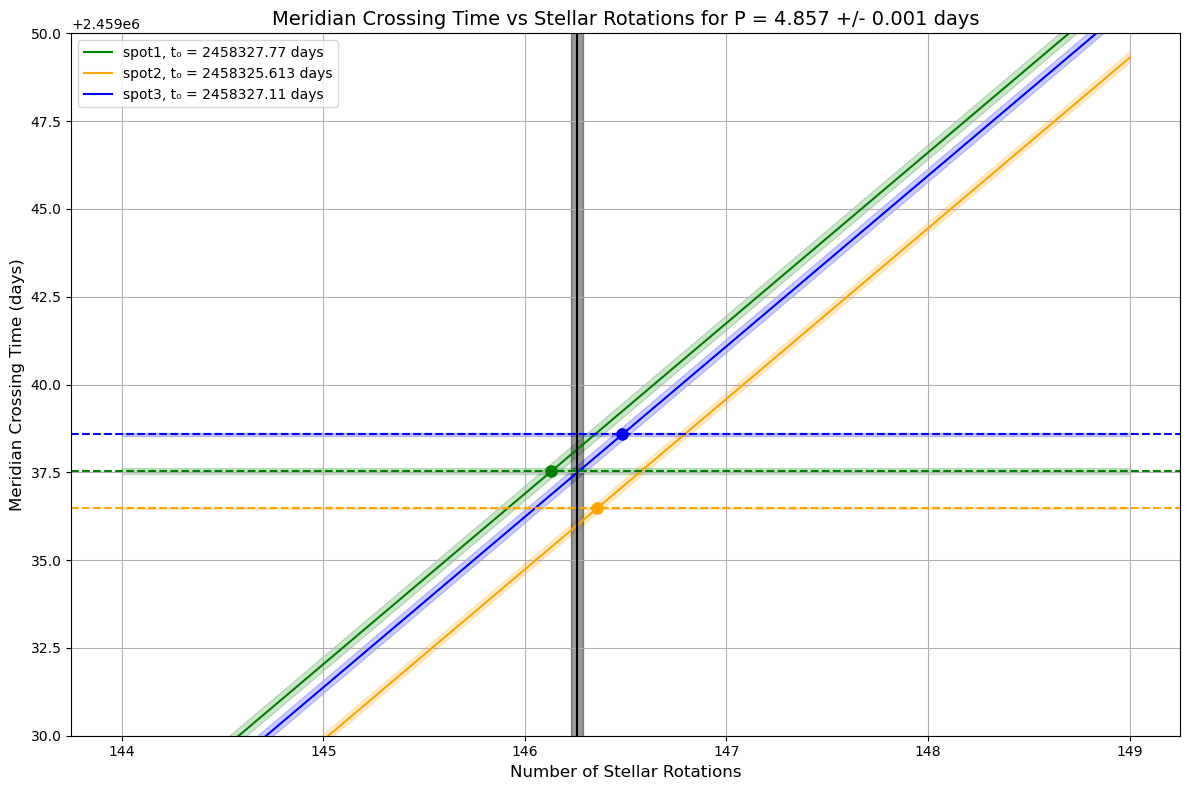

In [59]:
# Parameters
Prot = 4.857  # stellar rotation period in days
Prot_err = 0.001
n_rotations = 149  # number of stellar rotations to plot
start_times = [2458327.77, 2458325.613, 2458327.11]  # different initial crossing times (in days)
start_time_errors = [0.06, 0.006, 0.04]

end_times = [2459037.53, 2459036.47, 2459038.58]
end_time_errors = [0.08, 0.02, 0.05] 
# Generate data
rotations = np.arange(144, n_rotations + 1)  # 0 to n_rotations inclusive

plt.figure(figsize=(12, 8))
for idx, (t0, t0_error, spot_color) in enumerate(zip(start_times, start_time_errors, ['green','orange','blue'])):
    crossing_times = t0 + rotations * Prot
    plt.plot(rotations, crossing_times, color=spot_color, label=f"spot{idx+1}, t₀ = {t0} days")
    plt.fill_between(x=rotations, y1= (t0 - t0_error + rotations * (Prot - Prot_err)), y2= (t0 + t0_error + rotations * (Prot + Prot_err)), color=spot_color, alpha=0.2)

for idx, (end_time, end_time_error, spot_color) in enumerate(zip(end_times, end_time_errors, ['green','orange','blue'])):
    plt.axhline(end_time, color=spot_color, linestyle='dashed')
    plt.fill_between(x=rotations, y1=end_time-end_time_error, y2=end_time+end_time_error, color=spot_color, alpha=0.2)

    # Compute intersection rotation
    t0 = start_times[idx]
    rot_intersect = (end_time - t0) / Prot
    # Plot intersection point
    plt.plot(rot_intersect, end_time, 'o', color=spot_color, markersize=8, zorder=5)

plt.fill_betweenx(y=np.linspace(2459024, 2459055, 100), x1=(output_dic['sector_27']['LC_1']['t'][0]-output_dic['sector_1']['LC_1']['t'][0])/(Prot + 0.001), x2=(output_dic['sector_27']['LC_1']['t'][0]-output_dic['sector_1']['LC_1']['t'][0])/(Prot - 0.001), color='black', alpha=0.4)
plt.axvline((output_dic['sector_27']['LC_1']['t'][0]-output_dic['sector_1']['LC_1']['t'][0])/(Prot), color='black')
# Labels and formatting
plt.xlabel("Number of Stellar Rotations", fontsize=12)
plt.ylabel("Meridian Crossing Time (days)", fontsize=12)
plt.title(f"Meridian Crossing Time vs Stellar Rotations for P = {Prot} +/- {Prot_err} days", fontsize=14)
plt.ylim((2459030, 2459050))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

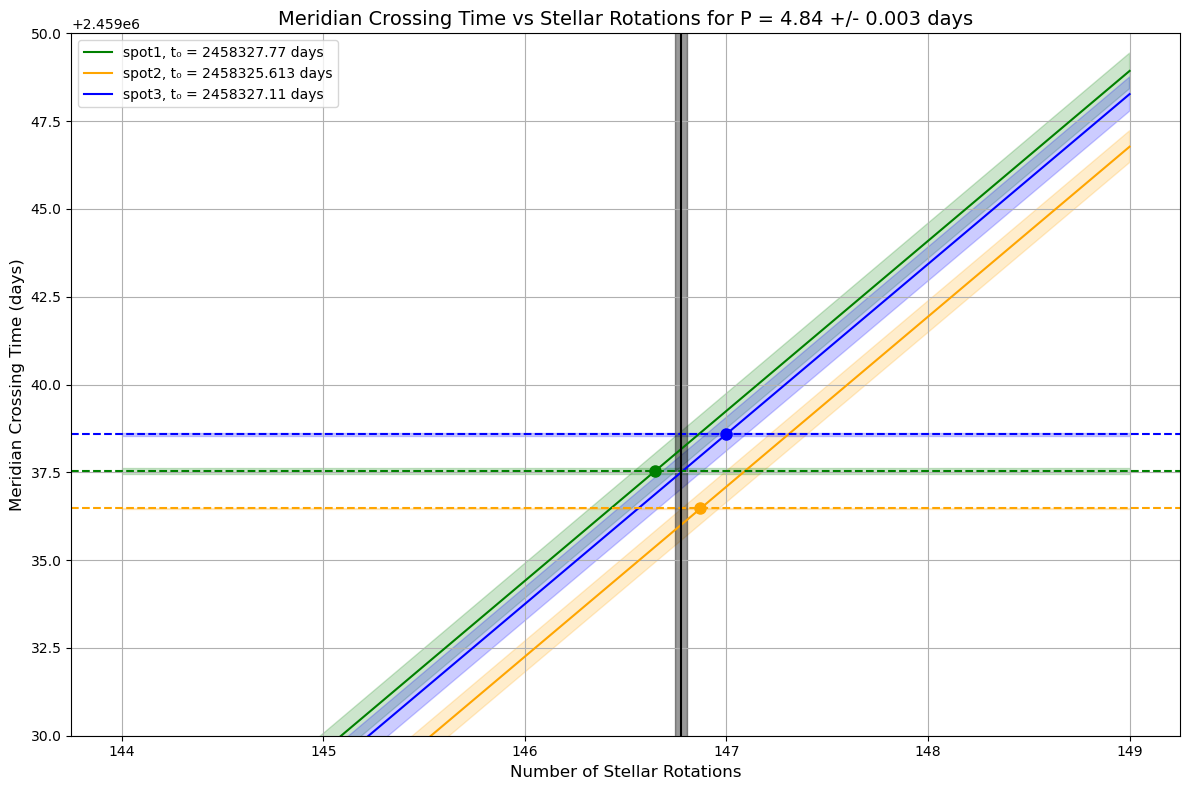

In [60]:
# Parameters
Prot = 4.840  # stellar rotation period in days
Prot_err = 0.003
n_rotations = 149  # number of stellar rotations to plot
start_times = [2458327.77, 2458325.613, 2458327.11]  # different initial crossing times (in days)
start_time_errors = [0.06, 0.006, 0.04]

end_times = [2459037.53, 2459036.47, 2459038.58]
end_time_errors = [0.08, 0.02, 0.05] 
# Generate data
rotations = np.arange(144, n_rotations + 1)  # 0 to n_rotations inclusive

plt.figure(figsize=(12, 8))
for idx, (t0, t0_error, spot_color) in enumerate(zip(start_times, start_time_errors, ['green','orange','blue'])):
    crossing_times = t0 + rotations * Prot
    plt.plot(rotations, crossing_times, color=spot_color, label=f"spot{idx+1}, t₀ = {t0} days")
    plt.fill_between(x=rotations, y1= (t0 - t0_error + rotations * (Prot - Prot_err)), y2= (t0 + t0_error + rotations * (Prot + Prot_err)), color=spot_color, alpha=0.2)

for idx, (end_time, end_time_error, spot_color) in enumerate(zip(end_times, end_time_errors, ['green','orange','blue'])):
    plt.axhline(end_time, color=spot_color, linestyle='dashed')
    plt.fill_between(x=rotations, y1=end_time-end_time_error, y2=end_time+end_time_error, color=spot_color, alpha=0.2)

    # Compute intersection rotation
    t0 = start_times[idx]
    rot_intersect = (end_time - t0) / Prot
    # Plot intersection point
    plt.plot(rot_intersect, end_time, 'o', color=spot_color, markersize=8, zorder=5)

plt.fill_betweenx(y=np.linspace(2459024, 2459055, 100), x1=(output_dic['sector_27']['LC_1']['t'][0]-output_dic['sector_1']['LC_1']['t'][0])/(Prot + 0.001), x2=(output_dic['sector_27']['LC_1']['t'][0]-output_dic['sector_1']['LC_1']['t'][0])/(Prot - 0.001), color='black', alpha=0.4)
plt.axvline((output_dic['sector_27']['LC_1']['t'][0]-output_dic['sector_1']['LC_1']['t'][0])/(Prot), color='black')
# Labels and formatting
plt.xlabel("Number of Stellar Rotations", fontsize=12)
plt.ylabel("Meridian Crossing Time (days)", fontsize=12)
plt.title(f"Meridian Crossing Time vs Stellar Rotations for P = {Prot} +/- {Prot_err} days", fontsize=14)
plt.ylim((2459030, 2459050))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()